In [5]:
import json
import numpy as np
import sklearn
import sklearn.metrics
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
import datetime
import os
import playlist
from playlist import *
data_dir = "/Users/pani/mpd/data/"

In [6]:
data_files = list(sorted(os.listdir(data_dir)))

In [7]:
data_files = data_files[:100]

In [8]:
all_playlists = []
for file_number, data_file in enumerate(data_files):
#     print(file_number, data_file)
    with open(data_dir + data_file) as file:
        data = json.load(file)
        playlists = data['playlists']
        all_playlists += playlists

In [9]:
playlist_list = all_playlists
len(playlist_list)

100000

In [10]:
import sys
sys.getsizeof(all_playlists)

846120

In [11]:
playlist_list[0]

{u'collaborative': u'false',
 u'duration_ms': 11532414,
 u'modified_at': 1493424000,
 u'name': u'Throwbacks',
 u'num_albums': 47,
 u'num_artists': 37,
 u'num_edits': 6,
 u'num_followers': 1,
 u'num_tracks': 52,
 u'pid': 0,
 u'tracks': [{u'album_name': u'The Cookbook',
   u'album_uri': u'spotify:album:6vV5UrXcfyQD1wu4Qo2I9K',
   u'artist_name': u'Missy Elliott',
   u'artist_uri': u'spotify:artist:2wIVse2owClT7go1WT98tk',
   u'duration_ms': 226863,
   u'pos': 0,
   u'track_name': u'Lose Control (feat. Ciara & Fat Man Scoop)',
   u'track_uri': u'spotify:track:0UaMYEvWZi0ZqiDOoHU3YI'},
  {u'album_name': u'In The Zone',
   u'album_uri': u'spotify:album:0z7pVBGOD7HCIB7S8eLkLI',
   u'artist_name': u'Britney Spears',
   u'artist_uri': u'spotify:artist:26dSoYclwsYLMAKD3tpOr4',
   u'duration_ms': 198800,
   u'pos': 1,
   u'track_name': u'Toxic',
   u'track_uri': u'spotify:track:6I9VzXrHxO9rA9A5euc8Ak'},
  {u'album_name': u'Dangerously In Love (Alben f\xfcr die Ewigkeit)',
   u'album_uri': u'spot

In [12]:
# Gets the number of tracks in each playlist
num_track_list = []
num_album_list = []
num_followers_list = []
num_artists_list = []
# hour is not interesting
modified_at_day_list = []
modified_at_weekday_list = []
modified_at_month_list = []
modified_at_year_list = []
for i in range(len(data['playlists'])):
    plylist = data['playlists'][i]
    num_track_list.append(plylist['num_tracks'])
    num_album_list.append(plylist['num_albums'])
    num_followers_list.append(plylist['num_followers'])
    num_artists_list.append(plylist['num_artists'])
    modified_at = datetime.datetime.fromtimestamp(plylist['modified_at'])
    modified_at_day_list.append(modified_at.day)
    modified_at_weekday_list.append(modified_at.weekday())
    modified_at_month_list.append(modified_at.month)
    modified_at_year_list.append(modified_at.year)

In [13]:
max(num_track_list)

247

In [14]:
min(num_track_list)

5

In [15]:
# https://stackoverflow.com/questions/20038011/trying-to-find-majority-element-in-a-list
from collections import Counter
c = Counter(num_track_list)
c.most_common()
value, count = c.most_common()[0]
print value

30


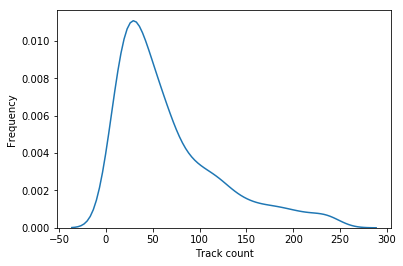

In [16]:
sns.kdeplot(num_track_list)
plt.xlabel('Track count')
plt.ylabel('Frequency')
plt.savefig("trackcount.png")
plt.show()

In [17]:
min(num_album_list)

3

In [18]:
max(num_album_list)

214

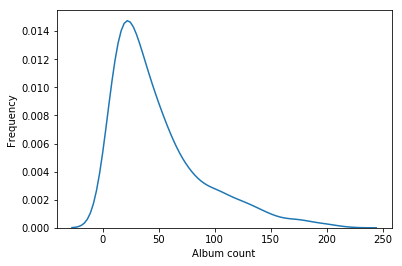

In [19]:
sns.kdeplot(num_album_list)
plt.xlabel('Album count')
plt.ylabel('Frequency')
plt.savefig("albumcount.png")
plt.show()

In [20]:
# https://stackoverflow.com/questions/20038011/trying-to-find-majority-element-in-a-list
from collections import Counter
c = Counter(num_album_list)
c.most_common()
value, count = c.most_common()[0]
print value

20


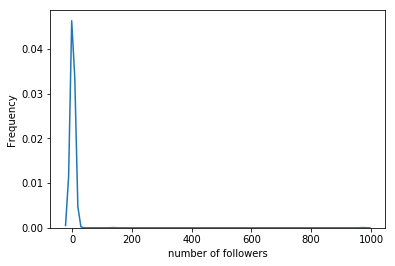

In [21]:
sns.kdeplot(num_followers_list)
plt.xlabel('number of followers')
plt.ylabel('Frequency')
plt.savefig("followercount.png")
plt.show()

In [22]:
min(num_followers_list)

1

In [23]:
max(num_followers_list)

973

In [24]:
# https://stackoverflow.com/questions/20038011/trying-to-find-majority-element-in-a-list
from collections import Counter
c = Counter(num_followers_list)
c.most_common()
value, count = c.most_common()[0]
print value

1


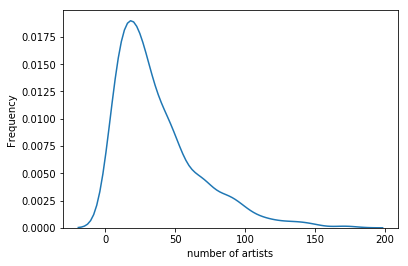

In [25]:
sns.kdeplot(num_artists_list)
plt.xlabel('number of artists')
plt.ylabel('Frequency')
plt.savefig("artistcount.png")
plt.show()

In [26]:
min(num_artists_list)

3

In [27]:
max(num_artists_list)

176

In [28]:
# https://stackoverflow.com/questions/20038011/trying-to-find-majority-element-in-a-list
from collections import Counter
c = Counter(num_artists_list)
c.most_common()
value, count = c.most_common()[0]
print value

8


In [29]:
# # Import necessary libraries
# import matplotlib.pyplot as plt
# import seaborn as sns


# plt.figure(figsize=(27,10))


# plt.subplot(451)
# sns.kdeplot(data=num_track_list)
# plt.xlabel('Track count')
# plt.ylabel('Frequency')

# plt.subplot(452)
# sns.kdeplot( data=num_track_list)
# plt.xlabel('Track count')
# plt.ylabel('Frequency')


# plt.subplot(453)
# sns.kdeplot( data=num_track_list)
# plt.xlabel('Track count')
# plt.ylabel('Frequency')

# plt.subplot(454)
# sns.kdeplot( data=num_track_list)
# plt.xlabel('Track count')
# plt.ylabel('Frequency')

# # plt.suptitle("title", size=12)
# plt.show()

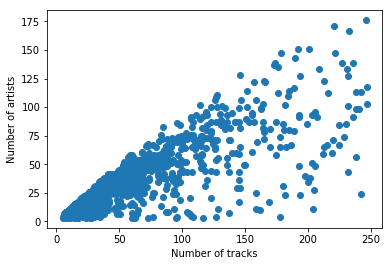

In [30]:
plt.scatter(num_track_list, num_artists_list)
plt.xlabel('Number of tracks')
plt.ylabel('Number of artists')
plt.savefig("trackartist.png")
plt.show()

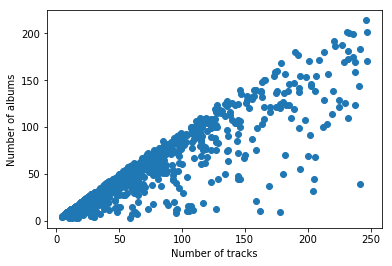

In [31]:
plt.scatter(num_track_list, num_album_list)
plt.xlabel('Number of tracks')
plt.ylabel('Number of albums')
plt.savefig("trackalbum.png")
plt.show()

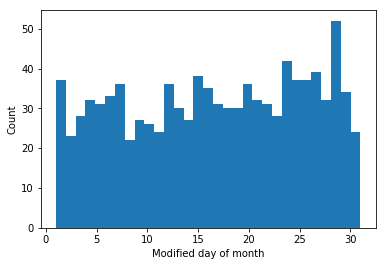

In [32]:
plt.hist(modified_at_day_list, 31)
plt.xlabel('Modified day of month')
plt.ylabel('Count')
plt.savefig("daymod.png")
plt.show()

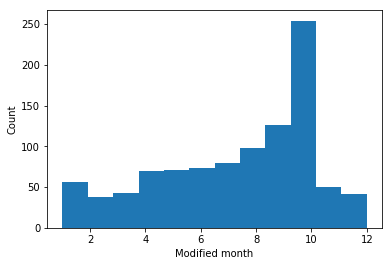

In [33]:
plt.hist(modified_at_month_list, 12)
plt.xlabel('Modified month')
plt.ylabel('Count')
plt.savefig("monthmod.png")
plt.show()

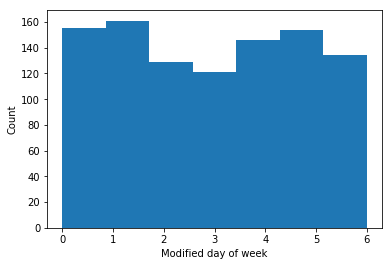

In [34]:
plt.hist(modified_at_weekday_list, 7)
plt.xlabel('Modified day of week')
plt.ylabel('Count')
plt.savefig("dayweekmod.png")
plt.show()

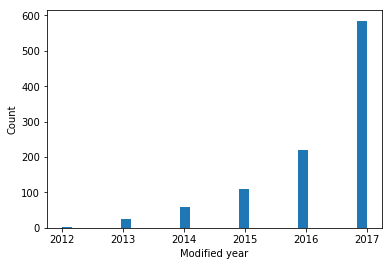

In [35]:
plt.hist(modified_at_year_list, 31)
plt.xlabel('Modified year')
plt.ylabel('Count')
plt.savefig("yearmod.png")
plt.show()

In [36]:
song_list = set([])
duration_list = []
for i in range(len(data['playlists'])):
    for j in range(data['playlists'][i]['num_tracks']):
        song_list.add(data['playlists'][i]['tracks'][j]['track_uri'])
        duration_list.append(data['playlists'][i]['tracks'][j]['duration_ms']/(60*1000))
song_list = list(song_list)
song_order_dict = dict(zip(song_list, range(len(song_list))))

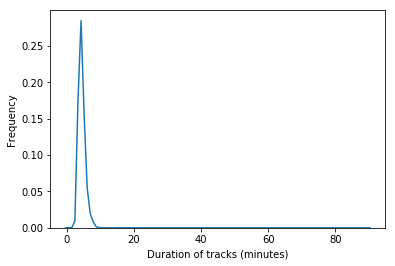

In [37]:
sns.kdeplot(duration_list)
plt.xlabel('Duration of tracks (minutes)')
plt.ylabel('Frequency')
plt.savefig("trackdur.png")
plt.show()

In [38]:
# https://stackoverflow.com/questions/20038011/trying-to-find-majority-element-in-a-list
from collections import Counter
c = Counter(duration_list)
c.most_common()
value, count = c.most_common()[0]
print value

3


In [39]:
len(song_list)

33991

In [40]:
features = np.zeros((len(data['playlists']), len(song_list)))

In [41]:
features.shape

(1000, 33991)

In [42]:
for i in range(len(data['playlists'])):
    for j in range(data['playlists'][i]['num_tracks']):
        track_uri = data['playlists'][i]['tracks'][j]['track_uri']
        k = song_order_dict[track_uri]
        features[i][k] = 1

In [43]:
# take top 100 tracks
top_features = list(reversed(features.sum(0).argsort()))[:100]
# cosine similarity of playlists by top 100 tracks
playlist_cosine_matrix = sklearn.metrics.pairwise.cosine_similarity(features[:,top_features])
# cosine similarity of tracks by top 100 tracks
track_cosine_matrix = sklearn.metrics.pairwise.cosine_similarity(features[:,top_features].T)

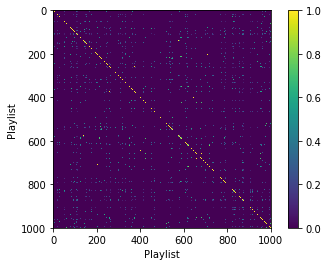

In [44]:
plt.imshow(playlist_cosine_matrix)
plt.colorbar()
plt.xlabel('Playlist')
plt.ylabel('Playlist')
plt.savefig("ppsim.png")
plt.show()

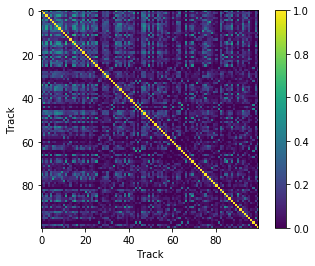

In [45]:
plt.imshow(track_cosine_matrix)
plt.colorbar()
plt.xlabel('Track')
plt.ylabel('Track')
plt.savefig("ttsim.png")
plt.show()

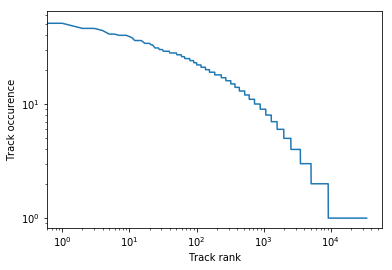

In [46]:
plt.loglog(sorted(features.sum(0), reverse=True))
plt.xlabel('Track rank')
plt.ylabel('Track occurence')
plt.savefig("pl.png")
plt.show()

In [47]:
artist_list = set([])
for i in range(len(data['playlists'])):
    for j in range(data['playlists'][i]['num_tracks']):
        artist_list.add(data['playlists'][i]['tracks'][j]['artist_uri'])
artist_list = list(artist_list)
artist_order_dict = dict(zip(artist_list, range(len(artist_list))))

In [48]:
artist_features = np.zeros((len(data['playlists']), len(artist_list)))

In [49]:
for i in range(len(data['playlists'])):
    for j in range(data['playlists'][i]['num_tracks']):
        artist_uri = data['playlists'][i]['tracks'][j]['artist_uri']
        k = artist_order_dict[artist_uri]
        artist_features[i][k] = 1

In [50]:
top_artist_features = list(reversed(artist_features.sum(0).argsort()))[:100]
artist_cosine_matrix = sklearn.metrics.pairwise.cosine_similarity(artist_features[:,top_artist_features].T)

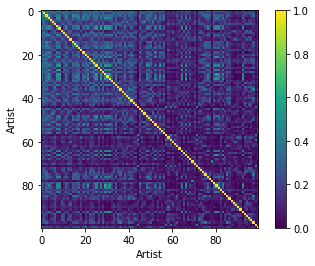

In [51]:
plt.imshow(artist_cosine_matrix)
plt.xlabel('Artist')
plt.ylabel('Artist')
plt.colorbar()
plt.savefig("aasim.png")
plt.show()

In [53]:
playlist_list = []
for i in range(len(data['playlists'])):
    playlist_list.append(data['playlists'][i])
    

In [54]:
playlist_names = []
for playlist in playlist_list:
    playlist_names.append(playlist['name'])

In [55]:
playlist_name_index = []
for play_list_name in playlist_names:
    playlist_name_index.append(playlist_names.index(play_list_name))


In [56]:
G = nx.Graph()
G.add_nodes_from(playlist_name_index)

In [57]:
def edgeCounter(playlist1, playlist2):
    tracks1 = get_tracks(playlist1)
    tracks2 = get_tracks(playlist2)
    common_set = tracks1.intersection(tracks2)
    edge_count = len(common_set)
    return edge_count   

In [58]:
def get_tracks(playlist):
    track_list = set([])
    for i in range(playlist['num_tracks']):
        track_list.add(playlist['tracks'][i]['track_uri'])
    return track_list

In [59]:
get_tracks(playlist_list[0])
get_tracks(playlist_list[1])
print()

()


In [60]:
edgeCounter(playlist_list[0], playlist_list[1])

0

In [61]:
def make_graph(G, playlist_list):
    for i in range(len(playlist_list)):
        for j in range(i+1, len(playlist_list)):
            edge_count = edgeCounter(playlist_list[i],playlist_list[j])
            if edge_count > 0:
                G.add_edge(i,j)

In [62]:
make_graph(G, playlist_list)
# nx.draw(G)

In [63]:
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 1000
Number of edges: 61354
Average degree: 122.7080


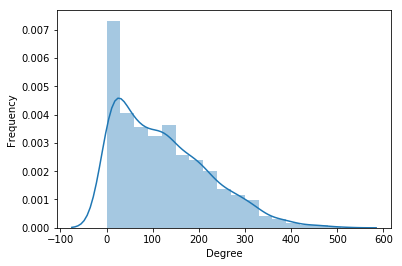

In [64]:
sns.distplot([d for n, d in G.degree()])
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.savefig("degfeq.png")
plt.show()

In [65]:
# Number of all unique tracks
all_tracks_in_playlists = set([])
for playlist in playlist_list:
    trackList =  get_tracks(playlist)
    all_tracks_in_playlists.update(trackList)
len(all_tracks_in_playlists)

33991

In [66]:
def fast_make_graph(G, playlist_list):
    graph_list = {}
    for i in range (len(playlist_list)):
        playlist = playlist_list[i]
        for j in range(playlist['num_tracks']):
            track_uri = playlist['tracks'][j]['track_uri']
            if track_uri not in graph_list:
                graph_list[track_uri] = set()
            graph_list[track_uri].add(i)
    for track_uri, node_list in graph_list.items():
        node_list = list(node_list)
        for i in range(len(node_list)):
            for j in range(i+1, len(node_list)):
                G.add_edge(node_list[i], node_list[j])
        

In [67]:
G2 = nx.Graph()
fast_make_graph(G2, playlist_list)

In [68]:
print(nx.info(G2))

Name: 
Type: Graph
Number of nodes: 982
Number of edges: 61354
Average degree: 124.9572


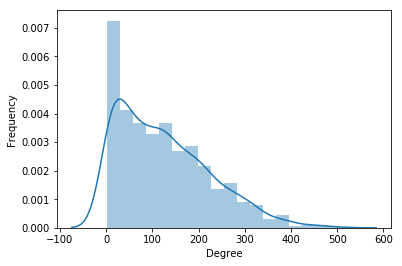

In [69]:
sns.distplot([d for n, d in G2.degree()])
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.savefig("degfeq.png")
plt.show()

In [70]:
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 1000
Number of edges: 61354
Average degree: 122.7080


In [71]:
nodes_triangles = nx.triangles(G2)

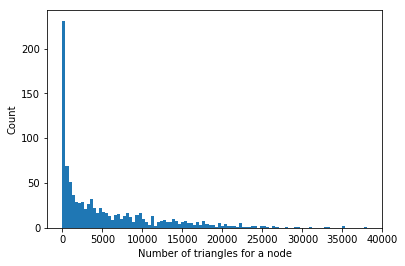

In [72]:
plt.hist(nodes_triangles.values(), 100)
plt.xlabel('Number of triangles for a node')
plt.ylabel('Count')
plt.savefig("tribar.png")
plt.show()

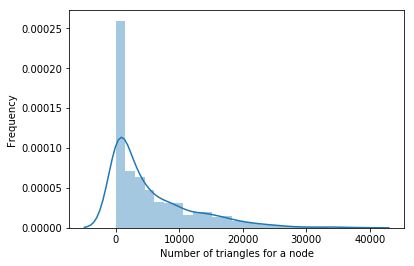

In [73]:
sns.distplot(list(nodes_triangles.values()))
plt.xlabel('Number of triangles for a node')
plt.ylabel('Frequency')
plt.savefig("trihist.png")
plt.show()

In [74]:
clustering_coeff = nx.clustering(G2)

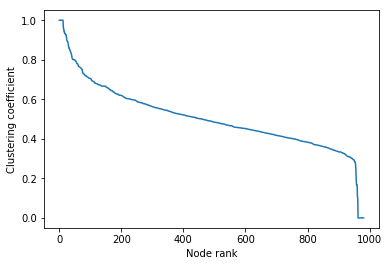

In [75]:
plt.plot(sorted(clustering_coeff.values(), reverse=True))
plt.xlabel('Node rank')
plt.ylabel('Clustering coefficient')
plt.savefig("clusc.png")
plt.show()

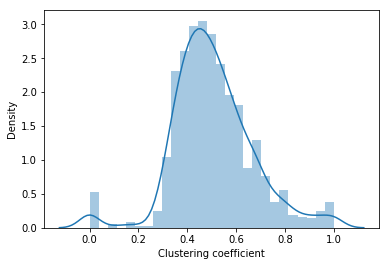

In [76]:
sns.distplot(list(clustering_coeff.values()))
plt.xlabel('Clustering coefficient')
plt.ylabel('Density')
plt.savefig("clusdensity.png")
plt.show()

In [77]:
# Average clustering coefficient:
print(nx.average_clustering(G2))

0.505978668537


In [71]:
# !pip install networkx